In [1]:
import numpy as np 
import pandas as pd
import networkx as nx

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from ucimlrepo import fetch_ucirepo

from Algorithms import A_C_N, A_C_G, DynamicProgrammingAlgorithms
from helper_functions import DecisionRuleCreatorFromDecisionTable, Reduction, R_AR, R_SR, R_AD, SAlphaStep

### Example to DecisionRuleCreatorFromDecisionTable

In [2]:
S = pd.DataFrame(
[[np.nan,1,1,1],
[0,1,0,2],
[0,0,0,2],
[0,0,2,3],
[0,1,np.nan,3],
[np.nan,0,np.nan,3]],
columns=['f1','f2','f3','class']
)
S

f1  f2   f3  class
0  NaN   1  1.0      1
1  0.0   1  0.0      2
2  0.0   0  0.0      2
3  0.0   0  2.0      3
4  0.0   1  NaN      3
5  NaN   0  NaN      3

In [3]:
alg = DynamicProgrammingAlgorithms(C="SR")

In [4]:
DT = alg.DT(S)
DT

{'f1': {0.0: {'f2': {1: {'Result': {4}}, 0: {'Result': {5}}}}}}

In [5]:
depth = alg.A_DP(S)
depth

2

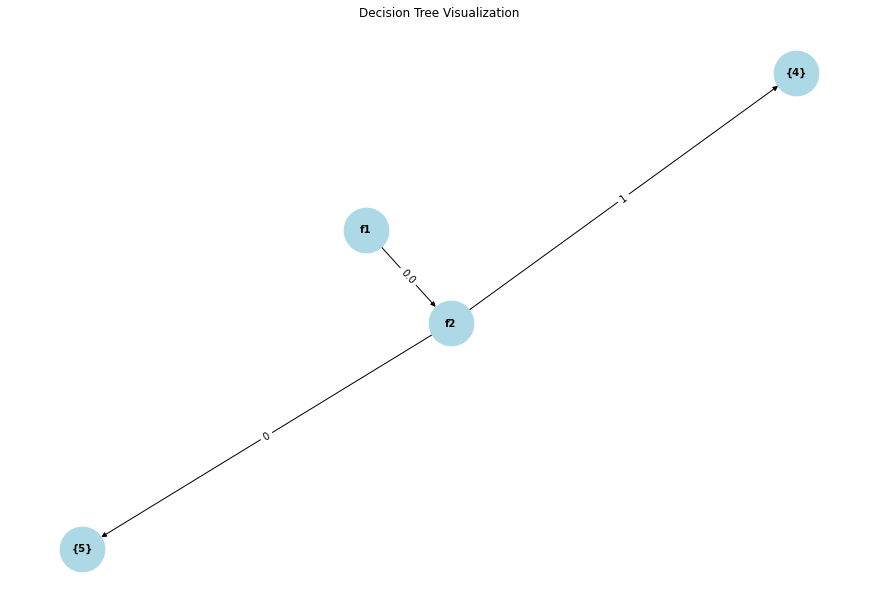

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# The given decision tree structure
decision_tree = DT

def parse_tree(tree, graph=None, parent=None, edge_label=''):
    """
    Recursive function to parse the decision tree and build the graph.

    Parameters:
    - tree: nested dictionary representing the decision tree
    - graph: the graph object from networkx
    - parent: the parent node name
    - edge_label: the label for the edge leading to the current node
    """
    if graph is None:
        graph = nx.DiGraph()

    for key, value in tree.items():
        if key == 'Result':
            # Leaf node
            node_name = f"{value}"
            graph.add_node(node_name)
            if parent is not None:
                graph.add_edge(parent, node_name, label=edge_label)
        else:
            # Decision node
            node_name = key
            graph.add_node(node_name)
            if parent is not None:
                graph.add_edge(parent, node_name, label=edge_label)
            for decision, subtree in value.items():
                parse_tree(subtree, graph, node_name, str(decision))
    return graph

# Parse the decision tree and create the graph
graph = parse_tree(decision_tree)

# Plotting
pos = nx.spring_layout(graph)  # Positioning the nodes based on spring layout
plt.figure(figsize=(12, 8))

# Draw nodes and edges
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")

# Draw edge labels
edge_labels = nx.get_edge_attributes(graph, 'label')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.title("Decision Tree Visualization")
plt.axis('off')  # Turn off the axis
plt.show()


In [ ]:
#############################################################################################################
############################################# INITIAL VERSION ###############################################
#############################################################################################################

class DynamicProgrammingAlgorithms:
    def __init__(self, C="AR"):
        """
        C - type of problem:
            "AR" - All Rules
            "EAR" - Extended All Rules
            "SR" - Some Rules
            "ESR" - Extended Some Rules
            "AD" - All Decisions
            "EAD" - Extended All Decisions
        """
        self.C = C
                
        self.R_C = Reduction(C)
            
            
    def DAG_C(self, S):
        """Construct the DAG based on the decision rule system S."""

        DAG = nx.MultiDiGraph()
        DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)

        def process_node(Q, DAG):
            """Process a node by checking applicable rules and updating the DAG."""
            if (self.R_C(Q).empty or self.R_C(Q).iloc[:, :-1].isna().all().all()):
                DAG.nodes[id(Q)]['processed'] = True
                DAG.nodes[id(Q)]['H'] = 0
                return

            for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
                for delta in S[a].dropna().unique():  # Find unique non-NaN values in column a
                    new_node_data = SAlphaStep(Q, (a, float(delta)))
                    not_equal = True
                    for node in DAG.nodes:
                        if new_node_data.equals(DAG.nodes[node]['data']):
                            DAG.add_edge(id(Q), node, label=(a,delta))
                            not_equal = False
                            break
                    if not_equal:
                        DAG.add_node(id(new_node_data), data=new_node_data, processed=False, H=None, best_attr=None)
                        DAG.add_edge(id(Q), id(new_node_data), label=(a,delta))
            # Mark the current node as processed
            DAG.nodes[id(Q)]['processed'] = True

        while not all(nx.get_node_attributes(DAG, 'processed').values()):
            # Find a node that is not processed
            for node in DAG.nodes:
                if not DAG.nodes[node]['processed']:
                    process_node(DAG.nodes[node]['data'], DAG)
                    break # Move to next iteration after processing a node
        return DAG
    
    
    def DAG_EC(self, S):
        """Construct the DAG based on the decision rule system S."""

        DAG = nx.MultiDiGraph()
        DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)

        def process_node(Q, DAG):
            """Process a node by checking applicable rules and updating the DAG."""
            if (self.R_C(Q).empty or self.R_C(Q).iloc[:, :-1].isna().all().all()):
                DAG.nodes[id(Q)]['processed'] = True
                DAG.nodes[id(Q)]['H'] = 0
                return

            for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
                for delta in np.append(S[a].dropna().unique(), "*"):  # Find unique non-NaN values in column a
                    new_node_data = SAlphaStep(Q, (a, delta if delta == "*" else float(delta)))
                    not_equal = True
                    for node in DAG.nodes:
                        if new_node_data.equals(DAG.nodes[node]['data']):
                            DAG.add_edge(id(Q), node, label=(a,delta))
                            not_equal = False
                            break
                    if not_equal:
                        DAG.add_node(id(new_node_data), data=new_node_data, processed=False, H=None, best_attr=None)
                        DAG.add_edge(id(Q), id(new_node_data), label=(a,delta))
            # Mark the current node as processed
            DAG.nodes[id(Q)]['processed'] = True

        while not all(nx.get_node_attributes(DAG, 'processed').values()):
            # Find a node that is not processed
            for node in DAG.nodes:
                if not DAG.nodes[node]['processed']:
                    process_node(DAG.nodes[node]['data'], DAG)
                    break # Move to next iteration after processing a node
        return DAG
    
    
    def DAG_update(self, DAG, node):

        # Step 1: If "H" is already a number, return it
        if DAG.nodes[node]['H']:
            return DAG.nodes[node]['H']

        # Step 2: Process the node based on its children
        children = list(DAG.successors(node))
        if not children:  # Terminal node
            DAG.nodes[node]['H'] = 0
        else:
            # Calculate the H value based on children and edge labels
            attribute_H_values = []
            for child in children:
                edges_data = DAG.get_edge_data(node, child)
                for edge in edges_data:
                    a, delta = edges_data[edge]['label']  # Assuming the edge label is stored as a tuple (a, delta)
                    child_H = DAG.nodes[child]['H'] if DAG.nodes[child].get('H') is not None else self.DAG_update(DAG, child)
                    attribute_H_values.append((a, child_H))

            # Group by attribute and find the min of the max H values for each attribute
            attribute_to_H = {}
            for a, h in attribute_H_values:
                if a in attribute_to_H:
                    attribute_to_H[a] = max(attribute_to_H[a], h)
                else:
                    attribute_to_H[a] = h

            # Now calculate the final H value for the node
            best_attr, min_H = min(attribute_to_H.items(), key=lambda x: x[1])

            DAG.nodes[node]['H'] = 1 + min_H
            DAG.nodes[node]['best_attr'] = best_attr

        return DAG.nodes[node]['H']
    
    def A_DP(self, S):
        
        if self.C in ["AR", "SR", "AD"]:
            DAG = self.DAG_C(S)
        else:
            DAG = self.DAG_EC(S)

        return self.DAG_update(DAG, id(S))
    
    def create_decision_tree(self, DAG, node):
        """
        Creates a decision tree from a given DAG and initial node.

        Args:
        DAG: The Directed Acyclic Graph from which to create the decision tree.
        node: The initial node in the DAG to start creating the decision tree.

        Returns:
        A decision tree represented as a nested dictionary.
        """
        # Base case: if the node is a terminal node, return its data as the leaf of the decision tree
        if DAG.nodes[node]['best_attr'] is None:
            return set(DAG.nodes[node]['data'].index)

        # Initialize the decision tree node with the best attribute
        best_attr = DAG.nodes[node]['best_attr']
        decision_tree_node = {best_attr: {}}

        # Iterate over outgoing edges of the node, but only consider edges that match the best_attr
        for _, child, edge_data in DAG.out_edges(node, data=True):
            a, delta = edge_data['label']
            if a == best_attr:
                # Recursively build the decision tree for the child node
                decision_tree_node[best_attr][delta] = self.create_decision_tree(DAG, child)

        return decision_tree_node
    
    def DT(self, S):
        
        if self.C in ["AR", "SR", "AD"]:
            DAG = self.DAG_C(S)
        else:
            DAG = self.DAG_EC(S)
            
        self.DAG_update(DAG, id(S))

        return self.create_decision_tree(DAG, id(S))


In [ ]:
#############################################################################################################
############################################## FIRST VERSION ################################################
#############################################################################################################

class DynamicProgrammingAlgorithms:
    def __init__(self, C="AR"):
        """
        C - type of problem:
            "AR" - All Rules
            "EAR" - Extended All Rules
            "SR" - Some Rules
            "ESR" - Extended Some Rules
            "AD" - All Decisions
            "EAD" - Extended All Decisions
        """
        self.C = C
                
        self.R_C = Reduction(C)
            
            
    def DAG_C(self, S):
        """Construct the DAG based on the decision rule system S."""

        DAG = nx.MultiDiGraph()
        DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)

        def process_node(Q, DAG):
            """Process a node by checking applicable rules and updating the DAG."""
            if (self.R_C(Q).empty or self.R_C(Q).iloc[:, :-1].isna().all().all()):
                DAG.nodes[id(Q)]['processed'] = True
                DAG.nodes[id(Q)]['H'] = 0
                return

            for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
                for delta in S[a].dropna().unique():  # Find unique non-NaN values in column a
                    new_node_data = SAlphaStep(Q, (a, float(delta)))
                    not_equal = True
                    for node in DAG.nodes:
                        if new_node_data.equals(DAG.nodes[node]['data']):
                            DAG.add_edge(id(Q), node, label=(a,delta))
                            not_equal = False
                            break
                    if not_equal:
                        DAG.add_node(id(new_node_data), data=new_node_data, processed=False, H=None, best_attr=None)
                        DAG.add_edge(id(Q), id(new_node_data), label=(a,delta))
            # Mark the current node as processed
            DAG.nodes[id(Q)]['processed'] = True

        while not all(nx.get_node_attributes(DAG, 'processed').values()):
            # Find a node that is not processed
            for node in DAG.nodes:
                if not DAG.nodes[node]['processed']:
                    process_node(DAG.nodes[node]['data'], DAG)
                    break # Move to next iteration after processing a node
        return DAG
    
    
    def DAG_EC(self, S):
        """Construct the DAG based on the decision rule system S."""

        DAG = nx.MultiDiGraph()
        DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)

        def process_node(Q, DAG):
            """Process a node by checking applicable rules and updating the DAG."""
            if (self.R_C(Q).empty or self.R_C(Q).iloc[:, :-1].isna().all().all()):
                DAG.nodes[id(Q)]['processed'] = True
                DAG.nodes[id(Q)]['H'] = 0
                return

            for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
                for delta in np.append(S[a].dropna().unique(), "*"):  # Find unique non-NaN values in column a
                    new_node_data = SAlphaStep(Q, (a, delta if delta == "*" else float(delta)))
                    not_equal = True
                    for node in DAG.nodes:
                        if new_node_data.equals(DAG.nodes[node]['data']):
                            DAG.add_edge(id(Q), node, label=(a,delta))
                            not_equal = False
                            break
                    if not_equal:
                        DAG.add_node(id(new_node_data), data=new_node_data, processed=False, H=None, best_attr=None)
                        DAG.add_edge(id(Q), id(new_node_data), label=(a,delta))
            # Mark the current node as processed
            DAG.nodes[id(Q)]['processed'] = True

        while not all(nx.get_node_attributes(DAG, 'processed').values()):
            # Find a node that is not processed
            for node in DAG.nodes:
                if not DAG.nodes[node]['processed']:
                    process_node(DAG.nodes[node]['data'], DAG)
                    break # Move to next iteration after processing a node
        return DAG
    
    
    def DAG_update(self, DAG, node):

        # Step 1: If "H" is already a number, return it
        if DAG.nodes[node]['H']:
            return DAG.nodes[node]['H']

        # Step 2: Process the node based on its children
        children = list(DAG.successors(node))
        if not children:  # Terminal node
            DAG.nodes[node]['H'] = 0
        else:
            # Calculate the H value based on children and edge labels
            attribute_H_values = []
            for child in children:
                edges_data = DAG.get_edge_data(node, child)
                for edge in edges_data:
                    a, delta = edges_data[edge]['label']  # Assuming the edge label is stored as a tuple (a, delta)
                    child_H = DAG.nodes[child]['H'] if DAG.nodes[child].get('H') is not None else self.DAG_update(DAG, child)
                    attribute_H_values.append((a, child_H))

            # Group by attribute and find the min of the max H values for each attribute
            attribute_to_H = {}
            for a, h in attribute_H_values:
                if a in attribute_to_H:
                    attribute_to_H[a] = max(attribute_to_H[a], h)
                else:
                    attribute_to_H[a] = h

            # Now calculate the final H value for the node
            best_attr, min_H = min(attribute_to_H.items(), key=lambda x: x[1])

            DAG.nodes[node]['H'] = 1 + min_H
            DAG.nodes[node]['best_attr'] = best_attr

        return DAG.nodes[node]['H']
    
    def A_DP(self, S):
        
        if self.C in ["AR", "SR", "AD"]:
            DAG = self.DAG_C(S)
        else:
            DAG = self.DAG_EC(S)

        return self.DAG_update(DAG, id(S))
    
    def create_decision_tree(self, DAG, node):
        """
        Creates a decision tree from a given DAG and initial node.

        Args:
        DAG: The Directed Acyclic Graph from which to create the decision tree.
        node: The initial node in the DAG to start creating the decision tree.

        Returns:
        A decision tree represented as a nested dictionary.
        """
        # Base case: if the node is a terminal node, return its data as the leaf of the decision tree
        if DAG.nodes[node]['best_attr'] is None:
            return set(self.R_C(DAG.nodes[node]['data']).index) # It is mandatory for SR, ESR, AD, EAD problems

        # Initialize the decision tree node with the best attribute
        best_attr = DAG.nodes[node]['best_attr']
        decision_tree_node = {best_attr: {}}

        # Iterate over outgoing edges of the node, but only consider edges that match the best_attr
        for _, child, edge_data in DAG.out_edges(node, data=True):
            a, delta = edge_data['label']
            if a == best_attr:
                # Recursively build the decision tree for the child node
                decision_tree_node[best_attr][delta] = self.create_decision_tree(DAG, child)

        return decision_tree_node
    
    def DT(self, S):
        
        if self.C in ["AR", "SR", "AD"]:
            DAG = self.DAG_C(S)
        else:
            DAG = self.DAG_EC(S)
            
        self.DAG_update(DAG, id(S))

        return self.create_decision_tree(DAG, id(S))


In [ ]:
#############################################################################################################
############################################# SECOND VERSION ################################################
#############################################################################################################

class DynamicProgrammingAlgorithms:
    def __init__(self, C="AR"):
        """
        C - type of problem:
            "AR" - All Rules
            "EAR" - Extended All Rules
            "SR" - Some Rules
            "ESR" - Extended Some Rules
            "AD" - All Decisions
            "EAD" - Extended All Decisions
        """
        self.C = C
                
        self.R_C = Reduction(C)
            
            
    def DAG_C(self, S):
        """Construct the DAG based on the decision rule system S."""

        DAG = nx.MultiDiGraph()
        DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)

        def process_node(Q, DAG):
            """Process a node by checking applicable rules and updating the DAG."""
            if (self.R_C(Q).empty or self.R_C(Q).iloc[:, :-1].isna().all().all()):
                DAG.nodes[id(Q)]['processed'] = True
                DAG.nodes[id(Q)]['H'] = 0
                return

            for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
                for delta in S[a].dropna().unique():  # Find unique non-NaN values in column a
                    new_node_data = SAlphaStep(Q, (a, float(delta)))
                    not_equal = True
                    for node in DAG.nodes:
                        if new_node_data.equals(DAG.nodes[node]['data']):
                            DAG.add_edge(id(Q), node, label=(a,delta))
                            not_equal = False
                            break
                    if not_equal:
                        DAG.add_node(id(new_node_data), data=new_node_data, processed=False, H=None, best_attr=None)
                        DAG.add_edge(id(Q), id(new_node_data), label=(a,delta))
            # Mark the current node as processed
            DAG.nodes[id(Q)]['processed'] = True

        while not all(nx.get_node_attributes(DAG, 'processed').values()):
            # Find a node that is not processed
            for node in DAG.nodes:
                if not DAG.nodes[node]['processed']:
                    process_node(DAG.nodes[node]['data'], DAG)
                    break # Move to next iteration after processing a node
        return DAG
    
    
    def DAG_EC(self, S):
        """Construct the DAG based on the decision rule system S."""

        DAG = nx.MultiDiGraph()
        S
        DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)

        def process_node(Q, DAG):
            """Process a node by checking applicable rules and updating the DAG."""
            if (self.R_C(Q).empty or self.R_C(Q).iloc[:, :-1].isna().all().all()):
                DAG.nodes[id(Q)]['processed'] = True
                DAG.nodes[id(Q)]['H'] = 0
                return

            for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
                for delta in np.append(S[a].dropna().unique(), "*"):  # Find unique non-NaN values in column a
                    new_node_data = SAlphaStep(Q, (a, delta if delta == "*" else float(delta)))
                    not_equal = True
                    for node in DAG.nodes:
                        if new_node_data.equals(DAG.nodes[node]['data']):
                            DAG.add_edge(id(Q), node, label=(a,delta))
                            not_equal = False
                            break
                    if not_equal:
                        DAG.add_node(id(new_node_data), data=new_node_data, processed=False, H=None, best_attr=None)
                        DAG.add_edge(id(Q), id(new_node_data), label=(a,delta))
            # Mark the current node as processed
            DAG.nodes[id(Q)]['processed'] = True

        while not all(nx.get_node_attributes(DAG, 'processed').values()):
            # Find a node that is not processed
            for node in DAG.nodes:
                if not DAG.nodes[node]['processed']:
                    process_node(DAG.nodes[node]['data'], DAG)
                    break # Move to next iteration after processing a node
        return DAG
    
    
    def DAG_update(self, DAG, node):

        # Step 1: If "H" is already a number, return it
        if DAG.nodes[node]['H']:
            return DAG.nodes[node]['H']

        # Step 2: Process the node based on its children
        children = list(DAG.successors(node))
        if not children:  # Terminal node
            DAG.nodes[node]['H'] = 0
        else:
            # Calculate the H value based on children and edge labels
            attribute_H_values = []
            for child in children:
                edges_data = DAG.get_edge_data(node, child)
                for edge in edges_data:
                    a, delta = edges_data[edge]['label']  # Assuming the edge label is stored as a tuple (a, delta)
                    child_H = DAG.nodes[child]['H'] if DAG.nodes[child].get('H') is not None else self.DAG_update(DAG, child)
                    attribute_H_values.append((a, child_H))

            # Group by attribute and find the min of the max H values for each attribute
            attribute_to_H = {}
            for a, h in attribute_H_values:
                if a in attribute_to_H:
                    attribute_to_H[a] = max(attribute_to_H[a], h)
                else:
                    attribute_to_H[a] = h

            # Now calculate the final H value for the node
            best_attr, min_H = min(attribute_to_H.items(), key=lambda x: x[1])

            DAG.nodes[node]['H'] = 1 + min_H
            DAG.nodes[node]['best_attr'] = best_attr

        return DAG.nodes[node]['H']
    
    def A_DP(self, S):
        
        if self.C in ["AR", "SR", "AD"]:
            DAG = self.DAG_C(S)
        else:
            DAG = self.DAG_EC(S)

        return self.DAG_update(DAG, id(S))
    
    def create_decision_tree(self, DAG, node):
        """
        Creates a decision tree from a given DAG and initial node.

        Args:
        DAG: The Directed Acyclic Graph from which to create the decision tree.
        node: The initial node in the DAG to start creating the decision tree.

        Returns:
        A decision tree represented as a nested dictionary.
        """
        # Base case: if the node is a terminal node, return its data as the leaf of the decision tree
        if DAG.nodes[node]['best_attr'] is None:
            return set(self.R_C(DAG.nodes[node]['data']).index)

        # Initialize the decision tree node with the best attribute
        best_attr = DAG.nodes[node]['best_attr']
        decision_tree_node = {best_attr: {}}

        # Iterate over outgoing edges of the node, but only consider edges that match the best_attr
        for _, child, edge_data in DAG.out_edges(node, data=True):
            a, delta = edge_data['label']
            if a == best_attr:
                # Recursively build the decision tree for the child node
                decision_tree_node[best_attr][delta] = self.create_decision_tree(DAG, child)

        return decision_tree_node
    
    def DT(self, S):
        
        if self.C in ["AR", "SR", "AD"]:
            DAG = self.DAG_C(S)
        else:
            DAG = self.DAG_EC(S)
            
        self.DAG_update(DAG, id(S))

        return self.create_decision_tree(DAG, id(S))


In [ ]:
S = pd.DataFrame(
[[np.nan,1,1,1],
[0,1,0,2],
[0,2,0,2],
[0,0,2,3],
[0,1,np.nan,3],
[np.nan,0,np.nan,3]],
columns=['f1','f2','f3','class']
)
S

In [ ]:
alg = DynamicProgrammingAlgorithms(C="SR")

In [ ]:
alg.DT(S)

In [ ]:
alg.A_DP(S)

In [ ]:
DAG.nodes[id(S)]

In [ ]:
children = list(DAG.successors(id(S)))
children

In [ ]:
child = children[0]

In [ ]:
DAG.nodes[child]

In [ ]:
DAG.get_edge_data(id(S), child)

In [ ]:
S

In [ ]:
SAlphaStep(S, (, delta)
SAlphaStep(S, ("f1", 1.0))

In [ ]:
S = pd.DataFrame(
[[1,1,1,1],
[0,1,0,2],
[1,1,0,2],
[0,0,1,3],
[1,0,0,3]],
columns=['f1','f2','f3','class']
)
S = DecisionRuleCreatorFromDecisionTable(S)
S

In [ ]:
def DAG_AR(S):
    """Construct the DAG based on the decision rule system S."""

    DAG = nx.MultiDiGraph()
    DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)

    def process_node(Q, DAG):
        """Process a node by checking applicable rules and updating the DAG."""
        if (Q.empty or Q.iloc[:, :-1].isna().all().all()):
            DAG.nodes[id(Q)]['processed'] = True
            DAG.nodes[id(Q)]['H'] = 0
            return

        for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
            for delta in np.append(Q[a].dropna().unique(), "*"):  # Find unique non-NaN values in column a
                print("S\n", Q)
                print("featue = ", a)
                print("delta = ", delta)
                new_node_data = SAlphaStep(Q, (a, delta))
                print("SAlphaStep\n",new_node_data)
                break
                not_equal = True
                for node in DAG.nodes:
                    if new_node_data.equals(DAG.nodes[node]['data']):
                        DAG.add_edge(id(Q), node, label=(a,delta))
                        not_equal = False
                        break
                if not_equal:
                    DAG.add_node(id(new_node_data), data=new_node_data, processed=False, H=None, best_attr=None)
                    DAG.add_edge(id(Q), id(new_node_data), label=(a,delta))
        # Mark the current node as processed
        DAG.nodes[id(Q)]['processed'] = True

#     while not all(nx.get_node_attributes(DAG, 'processed').values()):
#         # Find a node that is not processed
#         for node in DAG.nodes:
#             if not DAG.nodes[node]['processed']:
#                 process_node(DAG.nodes[node]['data'], DAG)
#                 break # Move to next iteration after processing a node
                
    process_node(DAG.nodes[id(S)]['data'], DAG)
    return DAG

In [ ]:
def process_node(Q, DAG):
    """Process a node by checking applicable rules and updating the DAG."""

    for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
        for delta in np.append(Q[a].dropna().unique(), "*"):  # Find unique non-NaN values in column a
            print(type(delta))
            print(delta)
            print("S\n", Q)
            print("featue = ", a)
            print("delta = ", delta)
            new_node_data = SAlphaStep(Q, (a, float(delta)))
            print("SAlphaStep\n",new_node_data)
            break

In [ ]:
process_node(S, DAG)

In [ ]:
alg.DT(S)

In [ ]:
edges = {0: {'label': ('f1', '1.0')}, 1: {'label': ('f1', '0.0')}, 2: {'label': ('f1', '*')}}

In [ ]:
for edge in edges:
    print(edges[edge]["label"])

In [ ]:
DAG = alg.DAG_AR(S)

In [ ]:
nx.draw(DAG)

In [ ]:
DAG.nodes[id(S)]

In [ ]:
for child in DAG.successors(id(S)):
    print(DAG.nodes[child])

In [ ]:
alg.DT(S)

In [ ]:
S

In [ ]:
Q = SAlphaStep(S, ("f1", 1))
Q

In [ ]:
set(Q.index)

In [ ]:
def DAG_AR(S):
    """Construct the DAG based on the decision rule system S."""

    DAG = nx.DiGraph()
    DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)

    def process_node(Q, DAG):
        """Process a node by checking applicable rules and updating the DAG."""
        if (R_SR(Q).empty or R_SR(Q).iloc[:, :-1].isna().all().all()):
            DAG.nodes[id(Q)]['processed'] = True
            DAG.nodes[id(Q)]['H'] = 0
            return

        for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
            for delta in Q[a].dropna().unique():  # Find unique non-NaN values in column a
                new_node_data = SAlphaStep(Q, (a, delta))
                not_equal = True
                for node in DAG.nodes:
                    if new_node_data.equals(DAG.nodes[node]['data']):
                        DAG.add_edge(id(Q), node, label=(a,delta))
                        not_equal = False
                        break
                if not_equal:
                    DAG.add_node(id(new_node_data), data=new_node_data, processed=False, H=None, best_attr="1")
#                     if id(Q) in DAG.nodes:
#                         print("yes")
#                     else:
#                         print("No")
                    DAG.add_edge(id(Q), id(new_node_data), label=(a,delta))
        # Mark the current node as processed
        DAG.nodes[id(Q)]['processed'] = True

    while not all(nx.get_node_attributes(DAG, 'processed').values()):
        # Find a node that is not processed
        for node in DAG.nodes:
            if not DAG.nodes[node]['processed']:
                process_node(DAG.nodes[node]['data'], DAG)
                break # Move to next iteration after processing a node
    return DAG

In [ ]:
S

In [ ]:
DAG_AR(S)

In [ ]:
DAG = nx.DiGraph()
DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)

In [ ]:
R_SR(DAG.nodes[id(S)]['data'])

In [ ]:
process_node(R_SR(DAG.nodes[id(S)]['data']), DAG)

In [ ]:
def process_node(Q, DAG):
    """Process a node by checking applicable rules and updating the DAG."""
    if (Q.empty or Q.iloc[:, :-1].isna().all().all()):
        DAG.nodes[id(Q)]['processed'] = True
        DAG.nodes[id(Q)]['H'] = 0
        return

    for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
        for delta in Q[a].dropna().unique():  # Find unique non-NaN values in column a
            new_node = SAlphaStep(Q, (a, delta))
            not_equal = True
            for node, data in DAG.nodes(data=True):
                if new_node.equals(data):
                    DAG.add_edge(Q, node, label=(a,delta))
                    not_equal = False
                    break
            if not_equal:
                DAG.add_node(id(new_node), data=new_node, processed=False, H=None, best_attr=None)
                DAG.add_edge(id(Q), id(new_node), label=(a,delta))
    # Mark the current node as processed
    DAG.nodes[id(Q)]['processed'] = True

In [ ]:
G = nx.MultiDiGraph()
G.add_node("1")
G.add_node("2")
G.add_edge("1", "2", label=("3", "4"))
G.add_edge("1", "2", label=("5", "6"))

for _, child, edge_data in G.out_edges("1", data=True):
    a, b = edge_data['label']
    print(a)

In [ ]:
for _, child, edge_data in G.out_edges("1", data=True):
    print(edge_data['label'])

In [ ]:
nx.draw(G)

In [ ]:
DecisionTable = pd.DataFrame(
[[1,1,1,1],
[0,1,0,2],
[1,1,0,2],
[0,0,1,3],
[1,0,0,3]],
columns=['f1','f2','f3','class']
)
DecisionTable

In [ ]:
S = DecisionRuleCreatorFromDecisionTable(DecisionTable)
S

In [ ]:
S = pd.DataFrame(
[[np.nan,1,np.nan,1],
[0,0,np.nan,2]],
columns=['f1','f2','f3','class']
)
S

In [ ]:
def A_DAG(S):
    """Construct the DAG based on the decision rule system."""
    
    DAG = nx.DiGraph()
    DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)
    
    def process_node(Q, DAG):
        """Process a node by checking applicable rules and updating the DAG."""
        if (Q.empty or Q.iloc[:, :-1].isna().all().all()):
            DAG.nodes[id(Q)]['processed'] = True
            DAG.nodes[id(Q)]['H'] = 0
            return
            
        for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
            for delta in Q[a].dropna().unique():  # Find unique non-NaN values in column a
                new_node = SAlphaStep(Q, (a, delta))
                not_equal = True
                for node, data in DAG.nodes(data=True):
                    if new_node.equals(data):
                        DAG.add_edge(Q, node, label=(a,delta))
                        not_equal = False
                        break
                if not_equal:
                    DAG.add_node(id(new_node), data=new_node, processed=False, H=None, best_attr=None)
                    DAG.add_edge(id(Q), id(new_node), label=(a,delta))
        # Mark the current node as processed
        DAG.nodes[id(Q)]['processed'] = True
    
    while not all(nx.get_node_attributes(DAG, 'processed').values()):
        # Find a node that is not processed
        for node in DAG.nodes:
            if not DAG.nodes[node]['processed']:
                process_node(DAG.nodes[node]['data'], DAG)
                break # Move to next iteration after processing a node
    return DAG


In [ ]:
DAG = A_DAG(S)

In [ ]:
nx.draw(DAG)

In [ ]:
def A_DP(DAG, node):

    # Step 1: If "H" is already a number, return it
    if DAG.nodes[node]['H']:
        return DAG.nodes[node]['H']
    
    # Step 2: Process the node based on its children
    children = list(DAG.successors(node))
    if not children:  # Terminal node
        DAG.nodes[node]['H'] = 0
    else:
        # Calculate the H value based on children and edge labels
        attribute_H_values = []
        for child in children:
            edge_data = DAG.get_edge_data(node, child)
            a, delta = edge_data['label']  # Assuming the edge label is stored as a tuple (a, delta)
            child_H = DAG.nodes[child]['H'] if DAG.nodes[child].get('H') is not None else A_DP(DAG, child)
            attribute_H_values.append((a, child_H))
        
        # Group by attribute and find the min of the max H values for each attribute
        attribute_to_H = {}
        for a, h in attribute_H_values:
            if a in attribute_to_H:
                attribute_to_H[a] = max(attribute_to_H[a], h)
            else:
                attribute_to_H[a] = h
        
        # Now calculate the final H value for the node
        best_attr, min_H = min(attribute_to_H.items(), key=lambda x: x[1])

        DAG.nodes[node]['H'] = 1 + min_H
        DAG.nodes[node]['best_attr'] = best_attr
    
    return DAG.nodes[node]['H']

In [ ]:
A_DP(DAG, id(S))

In [ ]:
DAG.nodes[id(S)]['best_attr']

In [ ]:
DAG.nodes[id(S)]

In [ ]:
DAG.out_edges(id(S), data=True)

In [ ]:
def create_decision_tree(DAG, node):
    """
    Creates a decision tree from a given DAG and initial node.
    
    Args:
    DAG: The Directed Acyclic Graph from which to create the decision tree.
    node: The initial node in the DAG to start creating the decision tree.
    
    Returns:
    A decision tree represented as a nested dictionary.
    """
    # Base case: if the node is a terminal node, return its data as the leaf of the decision tree
    if DAG.nodes[node]['best_attr'] is None:
        return {'data': DAG.nodes[node]['data']}
    
    # Initialize the decision tree node with the best attribute
    best_attr = DAG.nodes[node]['best_attr']
    decision_tree_node = {best_attr: {}}
    
    # Iterate over outgoing edges of the node, but only consider edges that match the best_attr
    for _, child, edge_data in DAG.out_edges(node, data=True):
        a, delta = edge_data['label']
        if a == best_attr:
            # Recursively build the decision tree for the child node
            decision_tree_node[best_attr][delta] = create_decision_tree(DAG, child)
    
    return decision_tree_node


In [ ]:
DT = create_decision_tree(DAG, id(S))

In [ ]:
DT

In [ ]:
DT = alg.DT(S)
DT

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# The given decision tree structure
decision_tree = {
    'f1': {
        0.0: {
            'f2': {
                1.0: {
                    'f3': {
                        1.0: {
                            'f4': {
                                1.0: {'data': "d1"}
                            }
                        },
                        0.0: {
                            'f4': {
                                1.0: {'data': "d2"}
                            }
                        }
                    }
                },
                0.0: {
                    'f3': {
                        0.0: {
                            'f4': {
                                1.0: {'data': "d3"}
                            }
                        }
                    }
                }
            }
        }
    }
}

def parse_tree(tree, graph=None, parent=None, edge_label=''):
    """
    Recursive function to parse the decision tree and build the graph.

    Parameters:
    - tree: nested dictionary representing the decision tree
    - graph: the graph object from networkx
    - parent: the parent node name
    - edge_label: the label for the edge leading to the current node
    """
    if graph is None:
        graph = nx.DiGraph()

    for key, value in tree.items():
        if key == 'data':
            # Leaf node
            node_name = f"{value}"
            graph.add_node(node_name)
            if parent is not None:
                graph.add_edge(parent, node_name, label=edge_label)
        else:
            # Decision node
            node_name = key
            graph.add_node(node_name)
            if parent is not None:
                graph.add_edge(parent, node_name, label=edge_label)
            for decision, subtree in value.items():
                parse_tree(subtree, graph, node_name, str(decision))
    return graph

# Parse the decision tree and create the graph
graph = parse_tree(decision_tree)

# Plotting
pos = nx.spring_layout(graph)  # Positioning the nodes based on spring layout
plt.figure(figsize=(12, 8))

# Draw nodes and edges
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")

# Draw edge labels
edge_labels = nx.get_edge_attributes(graph, 'label')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.title("Decision Tree Visualization")
plt.axis('off')  # Turn off the axis
plt.show()


In [ ]:
def A_DP(DAG, S):

    # Step 1: If "H" is already a number, return it
    if DAG.nodes[id(S)]['H']:
        return DAG.nodes[node]['H']
    
    # Step 2: Process the node based on its children
    children = list(DAG.successors(id(S)))
    if not children:  # Terminal node
        DAG.nodes[id(S)]['H'] = 0
    else:
        # Recursively label children, if not already done
        A_DP = [label_node_H(DAG, child) for child in children if DAG.nodes[child].get('H') is None]
        # Label "H" of the current node with the max "H" of its children
        DAG.nodes[node]['H'] = max([DAG.nodes[child]['H'] for child in children])
    
    return DAG.nodes[node]['H']

In [ ]:
def label_node_H_modified(G, node):
    """
    Labels the node 'H' with the updated rule considering edge labels (a, delta).
    
    Args:
    G: A networkx DiGraph object representing the DAG.
    node: The node to label 'H'.
    
    Returns:
    The 'H' value of the node.
    """
    # Step 1: If "H" is already a number, return it
    if G.nodes[node].get('H') is not None:
        return G.nodes[node]['H']
    
    # Check if the node is a terminal node
    children = list(G.successors(node))
    if not children:  # Terminal node
        G.nodes[node]['H'] = 0
    else:
        # Calculate the H value based on children and edge labels
        attribute_H_values = []
        for child in children:
            edge_data = G.get_edge_data(node, child)
            a, delta = edge_data['label']  # Assuming the edge label is stored as a tuple (a, delta)
            child_H = G.nodes[child]['H'] if G.nodes[child].get('H') is not None else label_node_H_modified(G, child)
            attribute_H_values.append((a, child_H))
        
        # Group by attribute and find the min of the max H values for each attribute
        attribute_to_H = {}
        for a, h in attribute_H_values:
            if a in attribute_to_H:
                attribute_to_H[a] = max(attribute_to_H[a], h)
            else:
                attribute_to_H[a] = h
        
        # Now calculate the final H value for the node
        if attribute_to_H:
            G.nodes[node]['H'] = 1 + min(attribute_to_H.values())
        else:  # If for some reason, there are no attributes, default to 0
            G.nodes[node]['H'] = 0
    
    return G.nodes[node]['H']


In [ ]:
def A_DP(DAG, S):
    if DAG.nodes[id(S)]['H']:
        return DAG.nodes[id(S)]['H']

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx


# Positions for all nodes
pos = nx.spring_layout(DAG)

# Draw nodes and edges
nx.draw_networkx_nodes(DAG, pos, node_size=200)
nx.draw_networkx_edges(DAG, pos)

# Draw edge labels
edge_labels = nx.get_edge_attributes(DAG, 'label')
nx.draw_networkx_edge_labels(DAG, pos, edge_labels=edge_labels)

# Remove axes
plt.axis('off')

# Show the plot
plt.show()


In [ ]:
id(DecisionRules)

In [ ]:
G.nodes[140398892141968]['data']

In [ ]:
df_str = DecisionRules.to_string()
df_hash = hash(df_str)


In [ ]:
df_str

In [ ]:
A = DecisionRules
A

In [ ]:
B = DecisionRules
B

In [ ]:
B = 2*B

In [ ]:
B

In [ ]:
A.equals(B)

### Example to A_C_N

In [ ]:
S = pd.DataFrame(
[[np.nan,1,1,np.nan,1],
[0,1,0,np.nan,2],
[0,0,0,np.nan,2],
[0,0,2,np.nan,3],
[0,1,np.nan,np.nan,3],
[np.nan,0,np.nan,np.nan,3]],
columns=['f1','f2','f3','f4','class']
)
S

In [ ]:
for v in S['f3'].dropna().unique():
    print(v)

In [ ]:
columns_with_non_nan = S.columns[S.notna().any()].tolist()[:-1]

In [ ]:
columns_with_non_nan

In [ ]:
delta = pd.DataFrame(
[[0,1,0,1]],
columns=['f1','f2','f3','f4']
)
delta = delta.loc[0]
delta

In [ ]:
ALG1 = A_C_N(C="AR", N="cover")
ALG1.solve(S, delta=delta)

In [ ]:
ALG2 = A_C_G(C="AR")
ALG2.solve(S, delta=delta)

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from helper_functions import R_SR, R_AD, SAlphaStep, SPlus, SMax



class A_C_G:
    def __init__(self, C="EAR"):
        """
         For each of the considered six problems, this is a polynomial time algorithm
         that, for a given tuple of attribute values, describes the work on this tuple 
         of a decision tree, which solves the problem. This algorithm is a completely 
         greedy algorithm by nature.
         
         C - type of problem:
            "AR" - All Rules
            "EAR" - Extended All Rules
            "SR" - Some Rules
            "ESR" - Extended Some Rules
            "AD" - All Decisions
            "EAD" - Extended All Decisions
        """
        self.C = C
        
    def solve(self, S, delta):
        """
        S - System of Decision Rules (pandas DataFrame)
        delta - tuple of attribute values from the set V_C (a row of a pandas df, without any NaN values)
        """
        
        # AR - All Rules problem, EAR - Extended All Rules problem
        if self.C in ["AR", "EAR"]:
            Q = S.copy()
            while True:
                # Step 1
                P = Q
                if (P.empty or P.iloc[:, :-1].isna().all().all()):
                    if P.empty:
#                             print("There is no such rule")
                        return
                    else:
                        row_indecies = P.index.tolist()
                        return S.loc[row_indecies]

                # Step 2
                else:
                    for column in P.columns:       # We choose an attribute ai ∈ A(P) with the minimum index i
                        if P[column].notna().any():
                            attr = column
                            break
                    alpha = (attr, delta[attr])
                    Q = SAlphaStep(P, alpha)
            
        # SR - Some Rules problem, ESR - Extended Some Rules problem
        elif self.C in ["SR", "ESR"]:
            Q = S.copy()
            while True:
                # Step 1
                P = R_SR(Q)
                if (P.empty or P.iloc[:, :-1].isna().all().all()):
                    if P.empty:
#                             print("There is no such rule")
                        return
                    else:
                        row_indecies = P.index.tolist()
                        return S.loc[row_indecies]

                # Step 2
                else:
                    for column in P.columns:       # We choose an attribute ai ∈ A(P) with the minimum index i
                        if P[column].notna().any():
                            attr = column
                            break
                    alpha = (attr, delta[attr])
                    Q = SAlphaStep(P, alpha)
                
        # AD - All Decisions problem, EAD - Extended All Decisions problem
        elif self.C in ["AD", "EAD"]:
            Q = S.copy()
            while True:
                # Step 1
                P = R_AD(Q)
                if (P.empty or P.iloc[:, :-1].isna().all().all()):
                    if P.empty:
#                             print("There is no such rule")
                        return
                    else:
                        row_indecies = P.index.tolist()
                        return S.loc[row_indecies]

                # Step 2
                else:
                    for column in P.columns:       # We choose an attribute ai ∈ A(P) with the minimum index i
                        if P[column].notna().any():
                            attr = column
                            break
                    alpha = (attr, delta[attr])
                    Q = SAlphaStep(P, alpha)
                
        # Wrong problem type      
        else: 
            raise ValueError("C must be one of {'AR', 'EAR', 'SR', 'ESR', 'AD', 'EAD'}")

In [ ]:
S = pd.DataFrame(
[[np.nan,1,1,np.nan,1],
[0,1,0,np.nan,2],
[0,0,0,np.nan,2],
[0,0,0,np.nan,3],
[0,1,np.nan,np.nan,3],
[np.nan,np.nan,np.nan,1,3]],
columns=['f1','f2','f3','f4','class']
)
S

In [ ]:
delta = pd.DataFrame(
[[0,1,0,1]],
columns=['f1','f2','f3','f4']
)
delta = delta.loc[0]
delta

In [ ]:
ALG = A_C_G(C="AD")
ALG.solve(S, delta=delta)

In [ ]:
P = pd.DataFrame(
[[np.nan,1,1,np.nan,1],
[np.nan,1,0,np.nan,2],
[np.nan,0,0,np.nan,2],
[np.nan,0,0,np.nan,3],
[np.nan,1,np.nan,np.nan,3],
[np.nan,np.nan,np.nan,1,3]],
columns=['f1','f2','f3','f4','class']
)
P

In [ ]:
for column in P.columns:
    if P[column].notna().any():
        attr = column
        break

In [ ]:
attr

In [ ]:
SAlphaStep(P, (attr, 0))

In [ ]:
from helper_functions import R_SR, R_AD, SAlphaStep, SPlus, SMax

In [ ]:
def R_SR(S):
    """
    input: S - system of decision rules (pandas DataFrame)
    output: subset of S which has reduced by SR reduction (pandas DataFrame)
    """
    to_remove = set()
    n = len(S)

    for i in range(n):
        for j in range(i+1, n):
            if i in to_remove or j in to_remove:
                continue
            r1, r2 = S.iloc[i][:-1], S.iloc[j][:-1] # Exclude the last column
            # Check if r1 is a subset of r2
            if all(np.isnan(r1[k]) or r1[k] == r2[k] for k in S.columns[:-1]):
                to_remove.add(j)
            # Check if r2 is a subset of r1
            elif all(np.isnan(r2[k]) or r2[k] == r1[k] for k in S.columns[:-1]):
                to_remove.add(i)

    return S.drop(S.index[list(to_remove)])


def R_AD(S):
    """
    input: S - system of decision rules (pandas DataFrame)
    output: subset of S which has reduced by AD reduction (pandas DataFrame)
    """
    to_remove = set()
    n = len(S)

    for i in range(n):
        for j in range(i+1, n):
            if i in to_remove or j in to_remove:
                continue
            r1, r2 = S.iloc[i], S.iloc[j]
            # Check if r1 is a subset of r2
            if all(np.isnan(r1[k]) or r1[k] == r2[k] for k in S.columns):
                to_remove.add(j)
            # Check if r2 is a subset of r1
            elif all(np.isnan(r2[k]) or r2[k] == r1[k] for k in S.columns):
                to_remove.add(i)

    return S.drop(S.index[list(to_remove)])


def SAlphaStep(S, alpha):
    """
    input: S - system of decision rules (pandas DataFrame)
           alpha - s tuple of the form (a_i = delta_j)
    output: S_alpha - subset of S as defined in the paper.(just for 1 attribute) (pandas DataFrame)
    """
    
    attr, value = alpha

    # Keep rows where the attr is NaN or equals the specified value
    S = S[(S[attr].isna()) | (S[attr] == value)]
    
    #Make NaN the values
    S.loc[~S[attr].isna(), attr] = np.nan

    return S


def SPlus(S):
    """
    input: S - system of decision rules (pandas DataFrame)
    output: S_plus - subset of S as defined in the paper. (pandas DataFrame)
    """
    non_nan_counts = S.notna().sum(axis=1)

    max_non_nan = non_nan_counts.max()

    S_plus = S[non_nan_counts == max_non_nan]
    
    return S_plus


def SMax(S_plus):
    """
    input: S_plus - system of decision rules with length d (pandas DataFrame)
    output: S_max - subset of S as defined in the paper. (pandas DataFrame)
    """

    columns_to_check = S_plus.columns[:-1]

    S_max = S_plus.drop_duplicates(subset=columns_to_check, keep='first')
    
    return S_max


def NCover(S_plus):
    """ 
    input: S_plus - system of decision rules with length d (pandas DataFrame)
    output: Node cover of S_plus, set of columns that covers all rows
    """
    B = set()

    while not S_plus.iloc[:, :-1].isna().all().all():
        # Select the first row
        r1 = S_plus.iloc[0][:-1]
        # Create A_r1
        A_r1 = set(r1[r1.notna()].index)
        # Add A_r1 to B
        B.update(A_r1)
        
        # Drop rows that have common elements in their index set with A_r1
        rows_to_drop = []
        for index, row in S_plus.iterrows():
            row = row[:-1]
            A_r = set(row[row.notna()].index)
            if A_r1 & A_r:  # Check for common elements
                rows_to_drop.append(index)
        
        S_plus = S_plus.drop(rows_to_drop)

    return B


def NGreedy(S_plus):
    """
    input: S_plus - subset of S as defined in the paper. (pandas DataFrame)
    output: Node cover of S_plus, set of indecies of columns that covers all rows
    """
    S_max = SMax(S_plus)
    
    B = set()
    uncovered_rows = set(S_max.index)

    while uncovered_rows:
        # Find the column that covers the maximum number of uncovered rows
        max_cover = 0
        max_col = None

        for col in S_max.columns[:-1]: # Exclude the last column
            if col in B:
                continue  # Skip columns that have already been chosen
            cover = S_max.index[S_max[col].notna()].intersection(uncovered_rows)
            if len(cover) > max_cover:
                max_cover = len(cover)
                max_col = col

        if max_col is None:
            # No more columns to cover rows, break out
            break

        # Add the column to B and remove covered rows from consideration
        B.add(max_col)
        uncovered_rows -= set(S_max.index[S_max[max_col].notna()])

    return B


In [ ]:
class A_C_N:
    def __init__(self, C="EAR", N="cover"):
        """
        C - type of problem:
            "AR" - All Rules
            "EAR" - Extended All Rules
            "SR" - Some Rules
            "ESR" - Extended Some Rules
            "AD" - All Decisions
            "EAD" - Extended All Decisions
        N - type of Node Cover Algorithm:
            "cover"
            "greedy"
        """
        self.C = C
        self.N = N
        
    def solve(self, S, delta):
        """
        S - System of Decision Rules (pandas DataFrame)
        delta - tuple of attribute values from the set V_C (a row of a pandas df, without any NaN values)
        """
        
        # AR - All Rules problem, EAR - Extended All Rules problem
        if self.C in ["AR", "EAR"]:
            if self.N == "cover": # with "cover" NodeCover method
                Q = S.copy()
                while True:
                    # Step 1
                    if (Q.empty or Q.iloc[:, :-1].isna().all().all()):
                        if Q.empty:
                            print("There is no such rule")
                            return
                        else:
                            row_indecies = Q.index.tolist()
                            return S.loc[row_indecies]
                       
                    # Step 2
                    else:
                        Q_plus = SPlus(Q)
                        B = NCover(Q_plus)
                        for attr in B:
                            alpha = (attr, delta[attr])
                            Q = SAlphaStep(Q, alpha)
                            
            elif self.N == "greedy": # with "cover" NodeCover method
                Q = S.copy()
                while True:
                    # Step 1
                    if (Q.empty or Q.iloc[:, :-1].isna().all().all()):
                        if Q.empty:
                            print("There is no such rule")
                            return
                        else:
                            row_indecies = Q.index.tolist()
                            return S.loc[row_indecies]
                    # Step 2
                    else:
                        Q_plus = SPlus(Q)
                        B = NGreedy(Q_plus)
                        for attr in B:
                            alpha = (attr, delta[attr])
                            Q = SAlphaStep(Q, alpha)
            
            else:
                raise ValueError("N must be 'cover' or 'greedy'.")
            
                
        # SR - Some Rules problem, ESR - Extended Some Rules problem
        elif self.C in ["SR", "ESR"]:
            if self.N == "cover": # with "cover" NodeCover method
                Q = S.copy()
                while True:
                    # Step 1
                    if (Q.empty or Q.iloc[:, :-1].isna().all().all()):
                        if Q.empty:
                            print("There is no such rule")
                            return
                        else:
                            row_indecies = Q.index.tolist()
                            return S.loc[row_indecies]
                       
                    # Step 2
                    else:
                        P = R_SR(Q)
                        P_plus = SPlus(P)
                        B = NCover(P_plus)
                        for attr in B:
                            alpha = (attr, delta[attr])
                            P = SAlphaStep(P, alpha)
                        Q = P
                            
            elif self.N == "greedy": # with "cover" NodeCover method
                Q = S.copy()
                while True:
                    # Step 1
                    if (Q.empty or Q.iloc[:, :-1].isna().all().all()):
                        if Q.empty:
                            print("There is no such rule")
                            return
                        else:
                            row_indecies = Q.index.tolist()
                            return S.loc[row_indecies]
                       
                    # Step 2
                    else:
                        P = R_SR(Q)
                        P_plus = SPlus(P)
                        B = NGreedy(P_plus)
                        for attr in B:
                            alpha = (attr, delta[attr])
                            P = SAlphaStep(P, alpha)
                        Q = P
            
            else:
                raise ValueError("N must be 'cover' or 'greedy'.")
                
        # AD - All Decisions problem, EAD - Extended All Decisions problem
        elif self.C in ["AD", "EAD"]:
            if self.N == "cover": # with "cover" NodeCover method
                Q = S.copy()
                while True:
                    # Step 1
                    if (Q.empty or Q.iloc[:, :-1].isna().all().all()):
                        if Q.empty:
                            print("There is no such rule")
                            return
                        else:
                            row_indecies = Q.index.tolist()
                            return S.loc[row_indecies]
                       
                    # Step 2
                    else:
                        P = R_AD(Q)
                        P_plus = SPlus(P)
                        B = NCover(P_plus)
                        for attr in B:
                            alpha = (attr, delta[attr])
                            P = SAlphaStep(P, alpha)
                        Q = P
                            
            elif self.N == "greedy": # with "cover" NodeCover method
                Q = S.copy()
                while True:
                    # Step 1
                    if (Q.empty or Q.iloc[:, :-1].isna().all().all()):
                        if Q.empty:
                            print("There is no such rule")
                            return
                        else:
                            row_indecies = Q.index.tolist()
                            return S.loc[row_indecies]
                       
                    # Step 2
                    else:
                        P = R_AD(Q)
                        P_plus = SPlus(P)
                        B = NGreedy(P_plus)
                        for attr in B:
                            alpha = (attr, delta[attr])
                            P = SAlphaStep(P, alpha)
                        Q = P
            
            else:
                raise ValueError("N must be 'cover' or 'greedy'.")
                
        # Wrong problem type      
        else: 
            raise ValueError("C must be one of {'AR', 'EAR', 'SR', 'ESR', 'AD', 'EAD'}")

In [ ]:
S = pd.DataFrame(
[[np.nan,1,1,np.nan,1],
[0,1,0,np.nan,2],
[0,0,0,np.nan,2],
[0,0,0,np.nan,3],
[0,1,np.nan,np.nan,3],
[np.nan,np.nan,np.nan,1,3]],
columns=['f1','f2','f3','f4','class']
)
S

In [ ]:
delta = pd.DataFrame(
[[0,1,0,2]],
columns=['f1','f2','f3','f4']
)
delta = delta.loc[0]
delta

In [ ]:
A_SR_N = A_C_N(C="AD", N="greedy")
A_SR_N.solve(S, delta=delta)

In [ ]:
S = pd.DataFrame(
[[np.nan,1,1,np.nan,1],
[0,1,0,np.nan,2],
[0,np.nan,0,np.nan,2],
[0,0,0,np.nan,3],
[0,1,np.nan,np.nan,3],
[np.nan,np.nan,np.nan,np.nan,3]],
columns=['f1','f2','f3','f4','class']
)
S

In [ ]:
def R_AD(S):
    to_remove = set()
    n = len(S)

    for i in range(n):
        for j in range(i+1, n):
            if i in to_remove or j in to_remove:
                continue
            r1, r2 = S.iloc[i], S.iloc[j]
            # Check if r1 is a subset of r2
            if all(np.isnan(r1[k]) or r1[k] == r2[k] for k in S.columns):
                to_remove.add(j)
            # Check if r2 is a subset of r1
            elif all(np.isnan(r2[k]) or r2[k] == r1[k] for k in S.columns):
                to_remove.add(i)

    return S.drop(S.index[list(to_remove)])


In [ ]:
R_AD(S)

In [ ]:
def R_SR(S):
    """
    Reduces S, with SR reduction
    input: S - system of decision rules (pandas DataFrame)
    output: SR_reduced - subset of S as defined in the paper (pandas DataFrame)
    """
    
    attr, value = alpha

    # Keep rows where the attr is NaN or equals the specified value
    S = S[(S[attr].isna()) | (S[attr] == value)]
    
    #Make NaN the values
    S.loc[~S[attr].isna(), attr] = np.nan

    return S

In [ ]:
S1 = SAlphaStep(S, ("f1", 0))
S1

In [ ]:
S2 = SAlphaStep(S1, ("f2", 1))
S2

In [ ]:
S3 = SAlphaStep(S2, ("f3", 1))
S3

In [ ]:
S4 = SAlphaStep(S3, ("f4", 1))
S4

In [ ]:
S4.loc[5]

In [ ]:
S4.index.tolist()

In [ ]:
S4.loc[[0,5]]

In [ ]:
r = S4.loc[5]
r

In [ ]:
r["class"]

In [ ]:
A_EAR_N = A_C_N(C="EAR", N="cover")
A_EAR_N.solve(S, delta=123)

In [ ]:
delta["f1"]

In [ ]:
S = pd.DataFrame(
[[np.nan,np.nan,np.nan,np.nan,1],
[np.nan,np.nan,np.nan,np.nan,2],
[np.nan,np.nan,np.nan,np.nan,2],
[np.nan,np.nan,np.nan,np.nan,3],
[np.nan,np.nan,np.nan,np.nan,3],
[np.nan,np.nan,np.nan,np.nan,3]],
columns=['f1','f2','f3','f4','class']
)
S

In [ ]:
def NGreedy(S_max):
    """
    input: S_max - subset of S as defined in the paper. (pandas DataFrame)
    output: Node cover of S_max, set of indecies of columns that covers all rows
    """
    B = set()
    uncovered_rows = set(S_max.index)

    # Number of columns excluding the last one
    num_columns = S_max.shape[1] - 1

    while uncovered_rows:
        max_cover = 0
        max_col = None

        for col_index in range(num_columns):
            if col_index in B:
                continue  # Skip columns that have already been chosen
                
            cover = S_max.index[S_max[col].notna()].intersection(uncovered_rows)
            if len(cover) > max_cover:
                max_cover = len(cover)
                max_col_index = col_index

        if max_col_index is None:
            # No more columns to cover rows, break out
            break

        # Add the column index to B and remove covered rows from consideration
        B.add(max_col_index)
        uncovered_rows -= set(S_max.index[S_max[max_col].notna()])

    return B

NGreedy(S)

In [ ]:
def NGreedy(S_max):
    """
    input: S_max - subset of S as defined in the paper. (pandas DataFrame)
    output: Node cover of S_max, set of indecies of columns that covers all rows
    """
    B = set()
    uncovered_rows = set(S_max.index)

    while uncovered_rows:
        # Find the column that covers the maximum number of uncovered rows
        max_cover = 0
        max_col = None

        for col in S_max.columns:
            if col in B:
                continue  # Skip columns that have already been chosen
            cover = S_max.index[S_max[col].notna()].intersection(uncovered_rows)
            if len(cover) > max_cover:
                max_cover = len(cover)
                max_col = col

        if max_col is None:
            # No more columns to cover rows, break out
            break

        # Add the column to B and remove covered rows from consideration
        B.add(max_col)
        uncovered_rows -= set(S_max.index[S_max[max_col].notna()])

    return B

NGreedy(S)

In [ ]:
r1 = S.iloc[0][:-1]

In [ ]:
A_r1 = set(r1[r1.notna()].index)
A_r1

In [ ]:
def NGreedy(S_max):
    """
    input: S_max - subset of S as defined in the paper. (pandas DataFrame)
    output: Node cover of S_max, set of indecies of columns that covers all rows
    """
    B = set()
    uncovered_rows = set(S_max.index)

    # Number of columns excluding the last one
    num_columns = S_max.shape[1] - 1

    while uncovered_rows:
        max_cover = 0
        max_col_index = None

        for col_index in range(num_columns):
            if col_index in B:
                continue  # Skip columns that have already been chosen

            cover = S_max.index[S_max.iloc[:, col_index].notna()].intersection(uncovered_rows)
            if len(cover) > max_cover:
                max_cover = len(cover)
                max_col_index = col_index

        if max_col_index is None:
            # No more columns to cover rows, break out
            break

        # Add the column index to B and remove covered rows from consideration
        B.add(max_col_index)
        uncovered_rows -= set(S_max.index[S_max.iloc[:, max_col_index].notna()])

    return B

In [ ]:
class A_C_N:
    def __init__(self, C="EAR", N="cover"):
        """
        C - type of problem:
            AR - All Rules
            EAR - Extended All Rules
            SR - Some Rules
            ESR - Extended Some Rules
            AD - All Decisions
            EAD - Extended All Decisions
        N - type of Node Cover Algorithm:
            cover
            greedy
        """
        self.C = C
        self.N = N
        
    def forward(self, S, delta):
        """
        S - System of Decision Rules (pandas DataFrame)
        delta - tuple of attribute values from the set V_C
        """
        if self.C == "EAR" and self.N == "cover":
            Q = S.copy()
            
            Q_plus = SPlus(Q)
            B = NCover(Q_plus)
            
            
            

In [ ]:
def SAlpha(S, alpha):
    """
    input: S - system of decision rules (pandas DataFrame)
           alpha - tuple of equations of the for ((a_i = delta_j), ...)
    output: S_alpha - subset of S as defined in the paper. (pandas DataFrame)
    """

    for col, value in alpha:
        # Keep rows where the column is NaN or equals the specified value
        S = S[(S[col].isna()) | (S[col] == value)]

    for col, _ in alpha:
        S.loc[~S[col].isna(), col] = np.nan

    return S

In [ ]:
SAlpha(S_max, (("f1", 0), ("f4", 3), ("f2", 1)))

In [ ]:
Ncover(S_plus_ex)

In [ ]:
r1 = S_plus_ex.iloc[0]
# Create A_r1: set of indices (integer positions) where r1 is not NaN
A_r1 = set(r1[r1.notna()].index.tolist())
A_r1

In [ ]:
def Ncover(S_plus):
    B = set()
    while len(S_plus):
        r1 = S_plus.iloc[0]
        A_r1 = set(np.where(r1[:-1].notna())[0])
        print(A_r1)
        B = B.union(A_r1)
        for row in range(len(S_plus)):
            drop 
            r = S_plus.iloc[row]
            A_r = set(np.where(r[:-1].notna())[0])
            print(A_r)
            if A_r1 & A_r:
                S_plus = S_plus.drop(row)
        print(S_plus)
        break
    return B
                
            

In [ ]:
Ncover(S_plus_ex)

In [ ]:
import pandas as pd

def process_dataframe(df):
    B = set()

    while not df.empty:
        # Select the first row
        r1 = df.iloc[0]
        # Create A_r1: set of indices (integer positions) where r1 is not NaN
        A_r1 = set(r1[r1.notna()].index.tolist())
        # Add A_r1 to B
        B.update(A_r1)
        
        # Drop rows that have common elements in their index set with A_r1
        rows_to_drop = []
        for index, row in df.iterrows():
            A_r = set(row[row.notna()].index.tolist())
            if A_r1 & A_r:  # Check for common elements
                rows_to_drop.append(index)
        
        df = df.drop(rows_to_drop)

    return B


In [ ]:
for row in S_plus_ex:
    print(row)

In [ ]:
r1 = S_plus_ex.iloc[0]
r1

In [ ]:
len(r1)

In [ ]:
len(S_plus)

In [ ]:
B = set()
r1 = S_plus_ex.iloc[0]
B = B.union([i for i in range(len(r1)) if r1[i] != np.nan])

In [ ]:
B

In [ ]:
if r1[0]!=np.nan:
    print("dff")

In [ ]:
r1[r1.notna()].index

In [ ]:
set(np.where(r1.notna())[0])

In [ ]:
np.where(r1.notna())

In [ ]:
non_nan_indices = set(np.where(row[:-1].notna())[0])

In [ ]:
set(np.where(r1[:-1].notna())[0])

In [ ]:
DecisionRules = pd.read_csv("./Datasets/car_DRules.csv")

In [ ]:
DecisionRules

In [ ]:
DecisionRules.iloc[579]

In [ ]:
S_plus = Splus(DecisionRules)
S_plus

In [ ]:
S_plus.loc[579][0]

In [ ]:
S_plus.iloc[0][0]

In [ ]:
S_max = Smax(S_plus)
S_max

In [ ]:
example_DRules = pd.read_csv("./Datasets/example_DRules.csv")
example_DRules

In [ ]:
S_plus = Splus(example_DRules)
S_plus

In [ ]:
example_DTable = pd.DataFrame(
[[1,1,1,1],
[0,1,0,2],
[0,1,0,2],
[0,0,1,3],
[0,0,1,3]],
columns=['f1','f2','f3','class']
)

In [ ]:
example_DTable

In [ ]:
S_plus = Splus(example_DTable)
S_plus

In [ ]:
S_max = Smax(S_plus)
S_max

In [ ]:
class DynamicProgrammingAlgorithms:
    def __init__(self, C="AR"):
        """
        C - type of problem:
            "AR" - All Rules
            "EAR" - Extended All Rules
            "SR" - Some Rules
            "ESR" - Extended Some Rules
            "AD" - All Decisions
            "EAD" - Extended All Decisions
        """
        self.C = C
                
        self.R_C = Reduction(C)
            
            
        
    def DAG_AR(self, S):
        """Construct the DAG based on the decision rule system S."""

        DAG = nx.DiGraph()
        DAG.add_node(id(S), data=S, processed=False, H=None, best_attr=None)

        def process_node(Q, DAG):
            """Process a node by checking applicable rules and updating the DAG."""
            if (self.R_C(Q).empty or self.R_C(Q).iloc[:, :-1].isna().all().all()):
                DAG.nodes[id(Q)]['processed'] = True
                DAG.nodes[id(Q)]['H'] = 0
                return

            for a in Q.columns[Q.notna().any()].tolist()[:-1]: # Finding columns with at least one non-NaN value
                for delta in Q[a].dropna().unique():  # Find unique non-NaN values in column a
                    new_node_data = SAlphaStep(Q, (a, delta))
                    not_equal = True
                    for node in DAG.nodes:
                        if new_node_data.equals(DAG.nodes[node]['data']):
                            DAG.add_edge(id(Q), node, label=(a,delta))
                            not_equal = False
                            break
                    if not_equal:
                        DAG.add_node(id(new_node_data), data=new_node_data, processed=False, H=None, best_attr=None)
                        DAG.add_edge(id(Q), id(new_node_data), label=(a,delta))
            # Mark the current node as processed
            DAG.nodes[id(Q)]['processed'] = True

        while not all(nx.get_node_attributes(DAG, 'processed').values()):
            # Find a node that is not processed
            for node in DAG.nodes:
                if not DAG.nodes[node]['processed']:
                    process_node(DAG.nodes[node]['data'], DAG)
                    break # Move to next iteration after processing a node
        return DAG
    
    def DAG_update(self, DAG, node):

        # Step 1: If "H" is already a number, return it
        if DAG.nodes[node]['H']:
            return DAG.nodes[node]['H']

        # Step 2: Process the node based on its children
        children = list(DAG.successors(node))
        if not children:  # Terminal node
            DAG.nodes[node]['H'] = 0
        else:
            # Calculate the H value based on children and edge labels
            attribute_H_values = []
            for child in children:
                edge_data = DAG.get_edge_data(node, child)
                a, delta = edge_data['label']  # Assuming the edge label is stored as a tuple (a, delta)
                child_H = DAG.nodes[child]['H'] if DAG.nodes[child].get('H') is not None else self.DAG_update(DAG, child)
                attribute_H_values.append((a, child_H))

            # Group by attribute and find the min of the max H values for each attribute
            attribute_to_H = {}
            for a, h in attribute_H_values:
                if a in attribute_to_H:
                    attribute_to_H[a] = max(attribute_to_H[a], h)
                else:
                    attribute_to_H[a] = h

            # Now calculate the final H value for the node
            best_attr, min_H = min(attribute_to_H.items(), key=lambda x: x[1])

            DAG.nodes[node]['H'] = 1 + min_H
            DAG.nodes[node]['best_attr'] = best_attr

        return DAG.nodes[node]['H']
    
    def A_DP(self, S):
        
        if self.C in ["AR", "SR", "AD"]:
            DAG = self.DAG_C(S)
        else:
            DAG = self.DAG_EC(S)
        
        return self.DAG_update(DAG, id(S))
    
    def create_decision_tree(self, DAG, node):
        """
        Creates a decision tree from a given DAG and initial node.

        Args:
        DAG: The Directed Acyclic Graph from which to create the decision tree.
        node: The initial node in the DAG to start creating the decision tree.

        Returns:
        A decision tree represented as a nested dictionary.
        """
        # Base case: if the node is a terminal node, return its data as the leaf of the decision tree
        if DAG.nodes[node]['best_attr'] is None:
            return {'data': DAG.nodes[node]['data']}

        # Initialize the decision tree node with the best attribute
        best_attr = DAG.nodes[node]['best_attr']
        decision_tree_node = {best_attr: {}}

        # Iterate over outgoing edges of the node, but only consider edges that match the best_attr
        for _, child, edge_data in DAG.out_edges(node, data=True):
            a, delta = edge_data['label']
            if a == best_attr:
                # Recursively build the decision tree for the child node
                decision_tree_node[best_attr][delta] = self.create_decision_tree(DAG, child)

        return decision_tree_node
    
    def DT(self, S):
        
        if self.C in ["AR", "SR", "AD"]:
            DAG = self.DAG_C(S)
        else:
            DAG = self.DAG_EC(S)
            
        self.DAG_update(DAG, id(S))

        return self.create_decision_tree(DAG, id(S))


In [ ]:
S = pd.DataFrame(
[[1,1,1,1],
[0,1,0,2],
[1,1,0,2],
[0,0,1,3],
[1,0,0,3]],
columns=['f1','f2','f3','class']
)
S

In [ ]:
S = DecisionRuleCreatorFromDecisionTable(S)
S

In [ ]:
alg = DynamicProgrammingAlgorithms("AR")

In [ ]:
alg.DT(S)

In [ ]:
{'f1': {1.0: {'f2': {1.0: {'f3': {1.0: {"d1"},0.0: {"d2"}}},
                     0.0: {'f3': {1.0: {"d"}}}}},
        0.0: {'f2': {1.0: {'f3': {0.0: {"d"}}},
                     0.0: {"d"}}}}}